In [1]:
# https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
import torch
print(torch.__version__)

0.3.1


In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt
from tqdm import tqdm_notebook, tqdm

In [3]:
PATH = './'
TRAIN = '../data/train_combined/'
TEST = '../data/test/'
LABELS = '../data/train_combined_all.csv'
SAMPLE = '../data/sample_submission.csv'

In [4]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [5]:
nw = 2   #number of workers for data loader
arch = resnet50 #specify target architecture

In [6]:
# train_names_png = list({f[:36] for f in os.listdir(TRAIN) if 'png' in f})
# train_names_jpg = []
# for f in tqdm_notebook(os.listdir(TRAIN)):
#     if 'png' in f:
#         continue
#     name = f.split('.')[0]
#     name = name.split('_')
#     if len(name) == 5:
#         name = name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]
#     else:
#         name = name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]+'_'+name[4]
#     if name not in train_names_jpg:
#         train_names_jpg.append(name)

# train_names = train_names_png + train_names_jpg
# test_names = list({f[:36] for f in os.listdir(TEST)})


# tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

HBox(children=(IntProgress(value=0, max=422712), HTML(value='')))

In [8]:
# import pickle
# with open('../cache/train_names', 'wb') as f:
#     pickle.dump(train_names, f)
# with open('../cache/train_names_png1', 'wb') as f:
#     pickle.dump(train_names_png, f)
# with open('../cache/train_names_png2', 'wb') as f:
#     pickle.dump(train_names_jpg, f)

In [7]:
len(train_names), len(train_names_jpg), len(train_names_png)

(105678, 74606, 31072)

In [8]:
train_names_jpg

['36372_410_G7_2',
 '51931_987_F7_2',
 '31438_331_D6_2',
 '17450_642_E8_6',
 '28977_320_C2_1',
 '55779_926_A9_2',
 '44811_559_G8_2',
 '28219_1176_B1_2',
 '31397_900_G9_1',
 '26678_607_F8_2',
 '46681_622_D7_4',
 '23162_221_B11_2',
 '40154_539_H11_3',
 '52181_790_A12_2',
 '35781_410_D8_2',
 '47846_852_A1_3',
 '58559_1006_D3_1',
 '76065_1784_G5_1',
 '28730_274_H5_2',
 '31698_1179_D11_3',
 '10554_87_B3_2',
 '5651_27_B5_1',
 '63566_1241_F2_3',
 '77538_1757_F5_2',
 '26114_298_A6_2',
 '47541_715_A11_5',
 '3782_669_G12_4',
 '27962_281_E5_1',
 '50238_693_A12_1',
 '2899_1_A3_1',
 '63759_1231_F9_1',
 '63402_1202_D8_3',
 '28482_1201_D10_2',
 '20291_235_D4_2',
 '19223_154_B8_1',
 '44175_498_C11_1',
 '47533_1145_D10_1',
 '17616_971_G7_2',
 '4201_69_B2_1',
 '45215_528_C1_3',
 '21799_si15_G6_3',
 '22642_626_H6_1',
 '61739_1080_D7_1',
 '71765_1343_A4_1',
 '45861_802_B11_2',
 '19269_611_F2_2',
 '29579_365_B12_2',
 '51024_876_D9_1',
 '36304_1011_E2_2',
 '28885_564_H9_1',
 '26502_214_H1_2',
 '14561_174_D5

In [16]:
import gc
def open_rgby(path,fid): #a function that reads RGBY image
 
#         colors = ['red','green','blue','yellow']
    colors = ['red','green','blue']
    flags = cv2.IMREAD_GRAYSCALE
    
    try:
        img_path = path+fid
        img1 = cv2.imread(img_path+'_red.png', flags)
        img2 = cv2.imread(img_path+'_green.png', flags)
        img3 = cv2.imread(img_path+'_blue.png', flags)
        img =  np.dstack([img1, img2, img3]).astype(np.float32)
        img = img/255.
        return img
    except:
        img_path2 = path+fid
        img1 = cv2.imread(img_path2+'_red.jpg', flags)
        img2 = cv2.imread(img_path2+'_green.jpg', flags)
        img3 = cv2.imread(img_path2+'_blue.jpg', flags)
        img =  np.dstack([img1, img2, img3]).astype(np.float32)
        img = img/255.
        img = cv2.resize(img, (512, 512),cv2.INTER_AREA)
        return img
    return np.dstack([img1, img2, img3])
    

In [10]:
# ??FilesDataset

In [11]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
#         print(fnames)
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [12]:
# ??tfms_from_stats
path_to_train = '../data/train_combined'
data = pd.read_csv('../data/train_combined_all.csv')

In [13]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
#     stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    stats = A([0.08069, 0.05258, 0.05487], [0.13704, 0.10145, 0.15313])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [14]:
bs = 16
sz = 512
md = get_data(sz,bs)

In [17]:
# x_tot = np.zeros(3)
# x2_tot = np.zeros(3)
# for x,y in tqdm_notebook(iter(md.trn_dl)):
#     x = md.trn_ds.denorm(x).reshape(-1,3)
#     x_tot += x.mean(axis=0)
#     x2_tot += (x**2).mean(axis=0)

# channel_avr = x_tot/len(md.trn_dl)
# channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
# channel_avr,channel_std

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

(array([nan, nan, nan]), array([nan, nan, nan]))

In [23]:
# mean = 0
# x2_tot = 0
# count = 0
# M2 = 0
# for name, labels in tqdm(zip(data['Id'], data['Target'].str.split(' '))):
#     if name not in tr_n:
#         continue
#     file = os.path.join(path_to_train, name)
#     image = load_image(file, (512, 512))/255.
#     val = np.reshape(image[:,:,0], -1)
#     img_mean = np.mean(val)
#     img_std = np.std(val)
#     count = count + 1
#     mean = mean + img_mean
#     M2 = M2 + img_std
#     x2_tot += np.mean(val**2)
# print('red mean', mean/(count))
# print('red std', M2/(count))
# channel_std = np.sqrt(x2_tot/count - ((mean/count)**2))

# 31072it [05:35, 92.74it/s]
# red mean 0.08052112660092407
# red std 0.13001299317356493

In [24]:
# x_tot = np.zeros(4)
# x2_tot = np.zeros(4)
# for x,y in iter(md.trn_dl):
# #     print(x.shape)
# #     tmp =  md.trn_ds.denorm(x).reshape(16,-1)
#     x = md.trn_ds.denorm(x).reshape(-1,4)
# #     print(x.shape)
# #     x = x.cpu().numpy().reshape(-1,4)
# #     print(x.shape)
#     x_tot += x.mean(axis=0)
#     x2_tot += (x**2).mean(axis=0)

# channel_avr = x_tot/len(md.trn_dl)
# channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
# channel_avr,channel_std

# (array([0.08702, 0.06006, 0.06512, 0.08925]),
#  array([0.14109, 0.1055 , 0.15163, 0.14201]))

In [25]:
# ??md.trn_ds.denorm

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [19]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [20]:
sz = 512 #image size
bs = 16  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc]

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

 66%|██████▋   | 3949/5944 [13:07<06:11,  5.37it/s, loss=5.29]

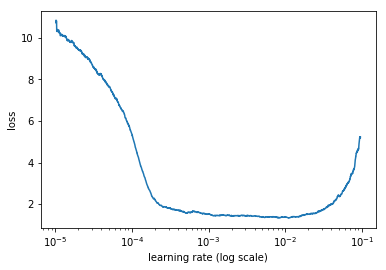

In [21]:
learner.lr_find()
learner.sched.plot()

In [22]:
lr = 1e-3
learner.fit(lr,1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                          
    0      1.221799   1.189967   0.945293  


[array([1.18997]), 0.9452930690211657]

In [23]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [24]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                          
    0      1.227277   7113.545799 0.741768  
    1      1.244978   5869.186106 0.843841                    
    2      1.224516   57330.967898 0.808343                   
    3      1.234236   3186.153651 0.94407                     
    4      1.233194   225161.272828 0.814832                  
    5      1.241774   72473.302901 0.94407                    
    6      1.222581   102920.309129 0.94407                   
    7      1.208679   126739.956035 0.94407                   


[array([126739.95603]), 0.9440696995245698]

In [25]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                          
    0      1.241604   28923.700127 0.94407   
    1      1.245552   123426.105809 0.536113                  
    2      1.254366   3971504.407835 0.936135                 
    3      1.241715   12956522.64648 0.936135                 
    4      1.213765   3920804.220288 0.902414                 
    5      1.233682   2786496.440575 0.870093                 
    6      1.244243   13447265.280091 0.94407                 
    7      1.219671   373748276.202877 0.936135               


[array([3.73748e+08]), 0.9361346917654149]

In [26]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                          
    0      1.225927   2882508.58327 0.936135  
    1      1.215866   334898.732305 0.94407                   
    2      1.221141   26436206.605602 0.94407                 
    3      1.208571   21209450.249811 0.936135                
    4      1.226919   2819637673.956094 0.94407               
    5      1.25505    1434531472742.9038 0.902414             
    6      1.240981   173337.827368 0.94407                   
    7      1.241035   628820.684093 0.936135                  


[array([628820.68409]), 0.9361346917654149]

In [27]:
learner.save('ResNet50_512_44Max')

In [28]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

/home/watts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [29]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [30]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5]
F1 macro:  0.020000778619118992
F1 macro (th = 0.5):  0.020000778619118992
F1 micro:  0.30311969909285347


/home/watts/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

/home/watts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [32]:
def save_pred(pred, th=0.5, fname='../submissions/sub44-max.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [33]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [35]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [36]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.5 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.5 0.1 0.1 0.1 0.5 0.1
 0.1]
Fractions:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Fractions (th = 0.5):  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [37]:
save_pred(pred_t,th_t,'../submissions/sub44-max-f.csv')

In [38]:
save_pred(pred_t,th,'../submissions/sub44-max-v.csv')
save_pred(pred_t,0.5,'../submissions/sub44-max-05.csv')

In [39]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'../submissions/sub44-max-c.csv')

In [40]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([40958.,  3072., 10871.,  3329.,  5130.,  5938.,  3725.,  9405.,   217.,   197.,   182.,  2194.,
         2233.,  1458.,  2692.,    63.,  1290.,   446.,  1893.,  3672.,   438., 13809.,  2729., 10345.,
          428., 37366.,   706.,   127.]),
 array([0.38757, 0.02907, 0.10287, 0.0315 , 0.04854, 0.05619, 0.03525, 0.089  , 0.00205, 0.00186, 0.00172,
        0.02076, 0.02113, 0.0138 , 0.02547, 0.0006 , 0.01221, 0.00422, 0.01791, 0.03475, 0.00414, 0.13067,
        0.02582, 0.09789, 0.00405, 0.35358, 0.00668, 0.0012 ]))

In [41]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'../submissions/sub44-max-t.csv')

Thresholds:  [0.5     0.07017 0.05    0.06851 0.05951 0.05642 0.06619 0.05    0.12372 0.12566 0.12725 0.07707 0.07671
 0.08539 0.07289 0.49456 0.08787 0.10927 0.08008 0.06649 0.10964 0.5     0.07261 0.05    0.1101  0.5
 0.10004 0.47552]
Fractions:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [42]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub44-max-t.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 446k/446k [00:13<00:00, 33.2kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName          date                 description  status    publicScore  privateScore  
----------------  -------------------  -----------  --------  -----------  ------------  
sub44-max-t.csv   2018-12-10 20:51:55               complete  0.019        None          
sub41-t-l.csv     2018-12-08 09:27:37               complete  0.541        None          
sub41-max-b.csv   2018-12-08 08:04:32               complete  0.478        None          
sub41-max-a.csv   2018-12-08 08:03:03               complete  0.479        None          
sub41-c.csv       2018-12-07 01:29:14               complete  0.493        None          
sub41-f.csv       2018-12-07 01:28:39               complete  0.481        None          
sub41-t.csv       2018-12-07 01:27:50               complete  0.498        None          
sub41-v.csv       2018-12-07 01:27:04      